In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os

In [2]:
df = pd.read_csv('./indicator_5_years.csv', sep=',')

In [3]:
df.head(10)

,Date,Close/Last,Volume,Open,High,Low
0,05/10/2024,395.18,3505595,395.25,395.8989,394.0958
1,05/09/2024,394.00,4141242,390.11,394.2600,390.0100
2,05/08/2024,390.48,2855082,388.34,390.9100,388.1900
3,05/07/2024,388.74,2428600,389.17,389.7500,388.3400
4,05/06/2024,388.45,2596106,388.32,388.7400,386.8300
5,05/03/2024,386.77,4471092,387.14,387.9900,385.0600
6,05/02/2024,382.23,3535552,381.15,382.9100,378.9000
7,05/01/2024,378.89,5731591,378.38,383.4800,377.9800
8,04/30/2024,378.13,3463622,382.46,382.7490,378.0800
9,04/29/2024,383.80,3265901,383.10,384.0300,382.0700


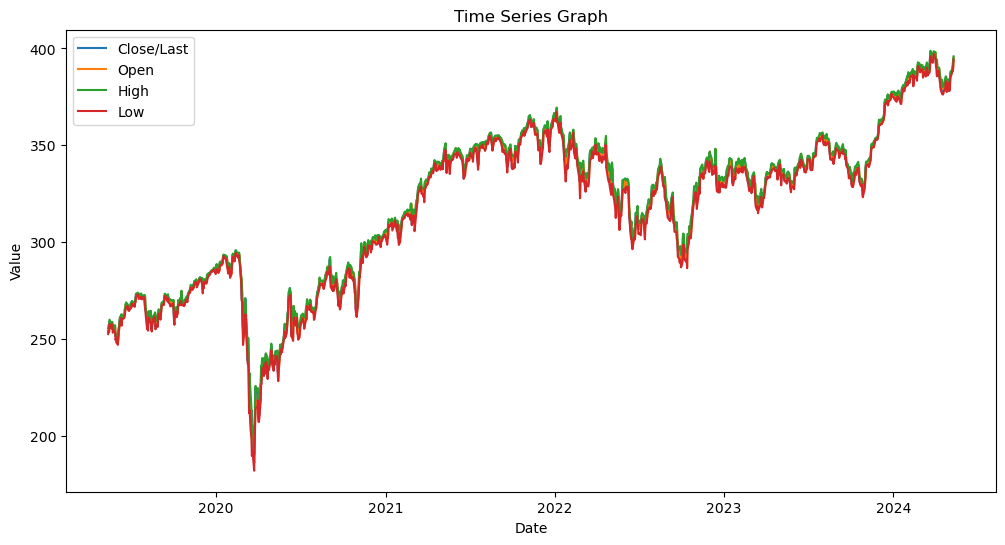

In [4]:

df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close/Last', data=df, label='Close/Last')
sns.lineplot(x='Date', y='Open', data=df, label='Open')
sns.lineplot(x='Date', y='High', data=df, label='High')
sns.lineplot(x='Date', y='Low', data=df, label='Low')


plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.legend(loc='upper left')

plt.show()


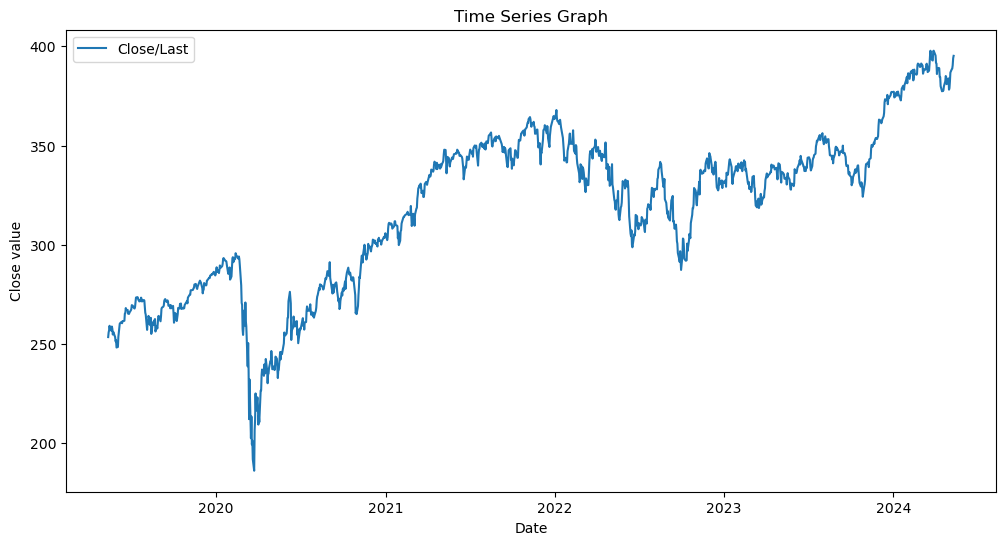

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close/Last', data=df, label='Close/Last')

plt.xlabel('Date')
plt.ylabel('Close value')
plt.title('Time Series Graph')
plt.legend(loc='upper left')

plt.show()

In [6]:

folder_path = 'datasets'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dataframes = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df_name = os.path.splitext(file)[0]  # Use the filename (without extension) as key
    dataframes[df_name] = pd.read_csv(file_path)

In [7]:
dataframes

{'Amazon_historical':             Date Close/Last    Volume     Open      High       Low
 0     05/10/2024    $187.48  34141770  $189.16  $189.892   $186.93
 1     05/09/2024    $189.50  43368380  $188.88   $191.70   $187.44
 2     05/08/2024    $188.00  26136350  $187.44   $188.43  $186.385
 3     05/07/2024    $188.76  34048900  $188.92   $189.94  $187.305
 4     05/06/2024    $188.70  34725300  $186.28  $188.745   $184.80
 ...          ...        ...       ...      ...       ...       ...
 2513  05/16/2014    $14.885  72703640   $14.64   $14.944  $14.5775
 2514  05/15/2014   $14.7595  85843920  $14.901    $14.96   $14.519
 2515  05/14/2014    $14.881  66460920  $15.125   $15.232   $14.833
 2516  05/13/2014    $15.232  69988460   $15.13    $15.28  $15.0375
 2517  05/12/2014    $15.143  74531500  $14.715   $15.167   $14.708
 
 [2518 rows x 6 columns],
 'Amgen_historical':             Date Close/Last   Volume     Open       High        Low
 0     05/10/2024    $310.15  2611880  $312.89

In [ ]:
company_csv_names = [
    "3M",
    "Amazon_historical",
    "American Express",
    "Amgen_historical",
    "Apple",
    "AT&T",
    "Boeing",
    "Caterpillar",
    "Chevron",
    "Cisco",
    "Coca-Cola",
    "Disney",
    "Dow",
    "DowDupont",
    "Dupont",
    "Exxon Mobil Corporation",
    "General Electric",
    "Goldman Sachs",
    "Home Depot",
    "Honeywell",
    "IBM",
    "Johnson & Johnson",
    "JPMorgan Chase",
    "McDonald's",
    "Merck",
    "Microsoft",
    "Nike",
    "Pfizer Inc.",
    "Procter & Gamble",
    "Raytheon Technologies Corporation",
    "Salesforce",
    "Travelers",
    "UnitedHealth Group",
    "United Technologies Corporation",
    "Verizon",
    "Visa",
    "Walgreens boots alliance",
    "Walmart"
]

In [9]:
df = pd.read_csv('./primeras_10ac.csv', sep=',')

In [10]:
df

,3M,amex,boeing,coca-cola,dow,ibm,jpmorgan,mac,merck,PyG,date,Fecha
0,98.9300,242.30,178.51,63.26,59.41,167.1500,198.77,275.00,130.0600,166.85,05/10/2024,2024-05-10
1,97.3300,239.14,181.25,62.88,59.45,166.2700,197.50,267.95,130.2300,166.04,05/09/2024,2024-05-09
2,96.3500,236.24,180.35,62.85,58.64,169.9000,195.65,268.49,129.5500,165.07,05/08/2024,2024-05-08
3,95.5400,234.66,176.71,62.62,58.36,168.3800,191.75,267.50,130.3800,165.76,05/07/2024,2024-05-07
4,96.5900,234.33,178.35,62.35,57.34,168.6100,192.00,269.30,127.5700,164.44,05/06/2024,2024-05-06
...,...,...,...,...,...,...,...,...,...,...,...,...
2513,121.1453,87.50,130.81,40.89,NaN,181.0567,53.31,103.14,53.9186,80.33,NaN,NaN
2514,121.0166,87.60,131.21,40.52,NaN,180.4759,53.51,102.50,53.9379,80.53,NaN,NaN
2515,121.5488,88.46,132.99,40.89,NaN,182.6634,54.36,103.03,54.4011,81.17,NaN,NaN
2516,122.2613,89.09,133.45,41.11,NaN,186.0220,54.62,103.53,53.8028,81.61,NaN,NaN
